## Start model training:

- Simple classifier that uses cropped images from detectron2
- Even the images that are not cropped 

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim 
from torchvision import datasets
from torch.autograd import Variable
import numpy as np
import pandas as pd
import cv2
import argparse
import os
from PIL import Image, ImageEnhance, ImageOps
from tqdm import tqdm
import random
from sklearn.model_selection import KFold, StratifiedKFold
from torch.utils.data import ConcatDataset, SubsetRandomSampler, DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

load_dir = '../Global_embeddings'
#load_dir_resnext = '../ResNext_embeddings'

#data = "../cropped_bird_dataset"
batch_size = 32
epochs = 50
lr = 0.01
momentum = 0.9
weight_decay = 5e-3
grad_clip = 5.
seed = 0
k_folds = 5
experiment='../experiment'

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

torch.manual_seed(seed)

# Features and labels of Inception v3
features_train = torch.load(os.path.join(load_dir, "birds_features_train.pt"), map_location=torch.device(device))
labels_train = torch.load(os.path.join(load_dir, "birds_labels_train.pt"), map_location=torch.device(device))

features_val = torch.load(os.path.join(load_dir, "birds_features_val.pt"), map_location=torch.device(device))
labels_val = torch.load(os.path.join(load_dir, "birds_labels_val.pt"), map_location=torch.device(device))

# Dataloaders
features_tensor = torch.stack([i for i in features_train])
labels_tensor = torch.stack([i for i in labels_train])
train_data = torch.utils.data.TensorDataset(features_tensor, labels_tensor) 

features_tensor = torch.stack([torch.Tensor(i) for i in features_val])
labels_tensor = torch.stack([i for i in labels_val])
val_data = torch.utils.data.TensorDataset(features_tensor,labels_tensor)

dataset = ConcatDataset([train_data, val_data])


# Features and labels of ResNext
#features_train = torch.load(os.path.join(load_dir_resnext, "birds_features_train.pt"), map_location=torch.device(device))
#labels_train = torch.load(os.path.join(load_dir_resnext, "birds_labels_train.pt"), map_location=torch.device(device))

#features_val = torch.load(os.path.join(load_dir_resnext, "birds_features_val.pt"), map_location=torch.device(device))
#labels_val = torch.load(os.path.join(load_dir_resnext, "birds_labels_val.pt"), map_location=torch.device(device))

# Dataloaders
#features_tensor = torch.stack([i for i in features_train])
#labels_tensor = torch.stack([i for i in labels_train])
#train_data = torch.utils.data.TensorDataset(features_tensor, labels_tensor) 

#features_tensor = torch.stack([torch.Tensor(i) for i in features_val])
#labels_tensor = torch.stack([i for i in labels_val])
#val_data = torch.utils.data.TensorDataset(features_tensor,labels_tensor)

#dataset_res = ConcatDataset([train_data, val_data])

# concatenate both datasets
#dataset = ConcatDataset([dataset_inc, dataset_res])

In [2]:
# Model
class Classifier(nn.Module):
    def __init__(self,embedding_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 20)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
def train_epoch(model, device, dataloader, loss_fn, optimizer, lr_scheduler):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        #lr_scheduler.step()
        train_loss += loss.item() * images.size(0)
        
        m = nn.Softmax(dim=1)
        probs = m(output)
        preds_classes = probs.max(1, keepdim=True)[1]
        train_correct += preds_classes.eq(labels.data.view_as(preds_classes)).sum()
            
            
        #scores, predictions = torch.max(output.data, 1)
        #train_correct += (predictions == labels).sum().item()
    
    return train_loss, train_correct


def valid_epoch(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = loss_fn(output, labels)
        valid_loss += loss.item() * images.size(0)
        
        m = nn.Softmax(dim=1)
        probs = m(output)
        preds_classes = probs.max(1, keepdim=True)[1]
        val_correct += preds_classes.eq(labels.data.view_as(preds_classes)).sum()
        
        
        #scores, predictions = torch.max(output.data, 1)
        #val_correct += (predictions == labels).sum().item()

    return valid_loss, val_correct

def reset_weights(model):
    """
    Try resetting model weights to avoid
    weight leakage.
    """
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()

##############################################
Fold 1
Epoch:1/50 AVG Training Loss:2.888 AVG Test Loss:2.640 AVG Training Acc 25.42 % AVG Test Acc 45.15 %
Epoch:2/50 AVG Training Loss:2.041 AVG Test Loss:1.300 AVG Training Acc 50.11 % AVG Test Acc 62.03 %
Epoch:3/50 AVG Training Loss:1.027 AVG Test Loss:0.888 AVG Training Acc 66.67 % AVG Test Acc 69.62 %
Epoch:4/50 AVG Training Loss:0.631 AVG Test Loss:0.589 AVG Training Acc 77.64 % AVG Test Acc 79.32 %
Epoch:5/50 AVG Training Loss:0.487 AVG Test Loss:0.553 AVG Training Acc 83.54 % AVG Test Acc 80.59 %
Epoch:6/50 AVG Training Loss:0.405 AVG Test Loss:0.505 AVG Training Acc 85.55 % AVG Test Acc 82.70 %
Epoch:7/50 AVG Training Loss:0.291 AVG Test Loss:0.418 AVG Training Acc 90.82 % AVG Test Acc 84.39 %
Epoch     8: reducing learning rate of group 0 to 5.0000e-03.
Epoch:8/50 AVG Training Loss:0.252 AVG Test Loss:0.451 AVG Training Acc 90.61 % AVG Test Acc 85.23 %
Epoch:9/50 AVG Training Loss:0.210 AVG Test Loss:0.409 AVG Training Acc 93.1

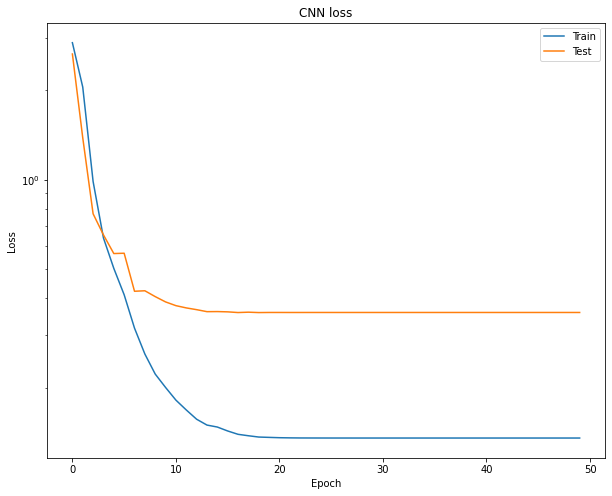

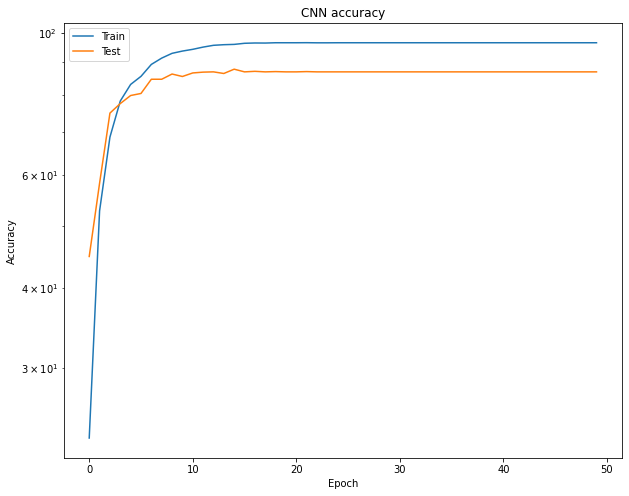

In [4]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

foldperf = {}

criterion = torch.nn.CrossEntropyLoss()

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
foldperf = {}
# For fold results
results = {}

criterion = torch.nn.CrossEntropyLoss()    

model_name = "classifier"

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):
    print("##############################################")
    print("Fold {}".format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    # Classifier
    model = Classifier(features_train[0].shape[0])
    reset_weights(model)
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay
    )
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=0, verbose=True)

    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_correct = train_epoch(
            model, device, train_loader, criterion, optimizer, lr_scheduler
        )
        test_loss, test_correct = valid_epoch(model, device, test_loader, criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        lr_scheduler.step(test_loss)

        print(
            "Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
                epoch + 1, epochs, train_loss, test_loss, train_acc, test_acc
            )
        )
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

        if test_acc >= 90:
            torch.save(model, f"../experiment/{model_name}_fold_{fold}_epoch_{epoch}.pt")
            print(f"save model at ../experiment/{model_name}_fold_{fold}_epoch_{epoch}.pt")

    foldperf["fold{}".format(fold + 1)] = history

    torch.save(model, f"../experiment/{model_name}_fold_{fold}.pt")
    print(f"save model at ../experiment/{model_name}_fold_{fold}.pt")

testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=k_folds

for fold, inner_dict in foldperf.items():
    for key, value in inner_dict.items():
        if key == "train_acc" or key == "test_acc":
            new_list = [x.cpu() for x in inner_dict[key]]
            inner_dict[key] = new_list

for f in range(1,k+1):
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f))) 

diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}

for i in range(epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_loss'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_acc'][i] for f in range(k)]))

# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('CNN loss')
plt.show()

# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('CNN accuracy')
plt.show()

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [8]:
# Test with Test Time Augmentation

# Test features
features_test = torch.load(os.path.join(load_dir, 'birds_features_test.pt'), map_location=torch.device(device))
features_tensor = torch.stack([i for i in features_test])

with open("../Global_embeddings/test_paths.txt", "r") as file:
    test_paths = file.read().split("\n")
    
#paths_tensor = torch.stack(test_paths)
    
#best_model_path = "../experiment/model_k_fold_global_84.pth"

# Loading trained model
#state_dict = torch.load(best_model_path)
#model = Classifier(features_test[0].shape[0])
#model.load_state_dict(state_dict)
model.eval()

Classifier(
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=20, bias=True)
)

In [11]:
output_file = "../experiment/model_k_fold_global_84_kaggle.csv"

with open(output_file, "w") as file:
    file.write("Id,Category\n")
    for path, embedding in tqdm(zip(test_paths, features_tensor)):
        output = model(embedding)
        pred = output.data.max(0, keepdim=True)[1]
        file.write("%s,%d\n" % (path, pred))
    print(
        "Succesfully wrote "
        + output_file
        + ", you can upload this file to the kaggle competition website"
    )

517it [00:00, 3403.08it/s]

Succesfully wrote ../experiment/model_k_fold_global_84_kaggle.csv, you can upload this file to the kaggle competition website
